In [9]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import torchattacks

%matplotlib inline

# NOTE: This is a hack to get around "User-agent" limitations when downloading MNIST datasets
#       see, https://github.com/pytorch/vision/issues/3497 for more information
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)


######################################################################
# Implementation
# --------------
# 
# In this section, we will discuss the input parameters for the tutorial,
# define the model under attack, then code the attack and run some tests.
# 
# Inputs
# ~~~~~~
# 
# There are only three inputs for this tutorial, and are defined as
# follows:
# 
# -  **epsilons** - List of epsilon values to use for the run. It is
#    important to keep 0 in the list because it represents the model
#    performance on the original test set. Also, intuitively we would
#    expect the larger the epsilon, the more noticeable the perturbations
#    but the more effective the attack in terms of degrading model
#    accuracy. Since the data range here is :math:`[0,1]`, no epsilon
#    value should exceed 1.
# 
# -  **pretrained_model** - path to the pretrained MNIST model which was
#    trained with
#    `pytorch/examples/mnist <https://github.com/pytorch/examples/tree/master/mnist>`__.
#    For simplicity, download the pretrained model `here <https://drive.google.com/drive/folders/1fn83DF14tWmit0RTKWRhPq5uVXt73e0h?usp=sharing>`__.
# 
# -  **use_cuda** - boolean flag to use CUDA if desired and available.
#    Note, a GPU with CUDA is not critical for this tutorial as a CPU will
#    not take much time.
# 

epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "lenet_mnist_model.pth"
use_cuda=True


######################################################################
# Model Under Attack
# ~~~~~~~~~~~~~~~~~~
# 
# As mentioned, the model under attack is the same MNIST model from
# `pytorch/examples/mnist <https://github.com/pytorch/examples/tree/master/mnist>`__.
# You may train and save your own MNIST model or you can download and use
# the provided model. The *Net* definition and test dataloader here have
# been copied from the MNIST example. The purpose of this section is to
# define the model and dataloader, then initialize the model and load the
# pretrained weights.
# 

# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])), 
        batch_size=1, shuffle=True)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()


# PGD attack code
def pgd_attack(orig_image, image, alpha, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    adv_data = image + alpha*sign_data_grad
    # Find the difference between the perturbed image and the original image and project it within the epsilon range
    diff=torch.clamp(adv_data-orig_image,-epsilon,epsilon)
    # Finally add the original image and the difference and clip it within the [0,1] range
    perturbed_image= torch.clamp(orig_image+diff,0,1).detach()
    
    # Return the perturbed image
    return perturbed_image




CUDA Available:  True


In [13]:
def test( model, device, test_loader, alpha, epsilon ):
    attack = torchattacks.PGD(model, eps=epsilon, alpha=epsilon/4, steps=10, random_start=True)    
    correct = 0  #accuracy counter
    adv_examples = []
    
    correct2 = 0
    adv_examples2 = []

    # Loop over all examples in test set
    for data, target in test_loader:
        
        # Send the data and label to the device
        data, target = data.to(device), target.to(device)


        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue
        
        data2 = attack(data, target)
        
        orig_data = data
        pred = 0
        
        for i in range(10):
            data.requires_grad = True
            output = model(data)
            
            pred = output.max(1,keepdim=True)[1]
            
            # If attack is successful break the loop
            if pred.item() != target.item():
                break
                
            # Calculate the loss
            loss = F.nll_loss(output, target)

            # Zero all existing gradients
            model.zero_grad()

            # Calculate gradients of model in backward pass
            loss.backward()

            # Collect datagrad
            data_grad = data.grad.data

            # Call PGD Attack
            data = pgd_attack(orig_data, data, alpha, epsilon, data_grad)
            
        

        # Check for success
        output = model(data)
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
                
        # Check for success
        output2 = model(data2)
        final_pred2 = output2.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred2.item() == target.item():
            correct2 += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples2) < 5):
                adv_ex2 = data2.squeeze().detach().cpu().numpy()
                adv_examples2.append( (init_pred.item(), final_pred2.item(), adv_ex2) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples2) < 5:
                adv_ex2 = data2.squeeze().detach().cpu().numpy()
                adv_examples2.append( (init_pred.item(), final_pred2.item(), adv_ex2) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
    
    # Calculate final accuracy for this epsilon
    final_acc2 = correct2/float(len(test_loader))
    print("Epsilon: {}\tTorchAttacks Test Accuracy = {} / {} = {}".format(epsilon, correct2, len(test_loader), final_acc2))


    # Return the accuracy and an adversarial example
    return final_acc, adv_examples, final_acc2, adv_examples2


######################################################################
# Run Attack
# ~~~~~~~~~~
# 
# The last part of the implementation is to actually run the attack. Here,
# we run a full test step for each epsilon value in the *epsilons* input.
# For each epsilon we also save the final accuracy and some successful
# adversarial examples to be plotted in the coming sections. Notice how
# the printed accuracies decrease as the epsilon value increases. Also,
# note the :math:`\epsilon=0` case represents the original test accuracy,
# with no attack.
# 

accuracies = []
examples = []
accuracies2 = []
examples2 = []

# Run test for each epsilon
for eps in epsilons:
    alpha=eps/4
    acc, ex, acc2, ex2 = test(model, device, test_loader,alpha, eps)
    accuracies.append(acc)
    examples.append(ex)
    accuracies2.append(acc2)
    examples2.append(ex2)




Epsilon: 0	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0	TorchAttacks Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.05	Test Accuracy = 9278 / 10000 = 0.9278
Epsilon: 0.05	TorchAttacks Test Accuracy = 9280 / 10000 = 0.928
Epsilon: 0.1	Test Accuracy = 7609 / 10000 = 0.7609
Epsilon: 0.1	TorchAttacks Test Accuracy = 7670 / 10000 = 0.767
Epsilon: 0.15	Test Accuracy = 4114 / 10000 = 0.4114
Epsilon: 0.15	TorchAttacks Test Accuracy = 4401 / 10000 = 0.4401
Epsilon: 0.2	Test Accuracy = 1005 / 10000 = 0.1005
Epsilon: 0.2	TorchAttacks Test Accuracy = 1209 / 10000 = 0.1209
Epsilon: 0.25	Test Accuracy = 100 / 10000 = 0.01
Epsilon: 0.25	TorchAttacks Test Accuracy = 137 / 10000 = 0.0137
Epsilon: 0.3	Test Accuracy = 0 / 10000 = 0.0
Epsilon: 0.3	TorchAttacks Test Accuracy = 6 / 10000 = 0.0006


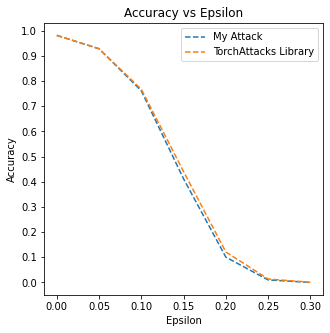

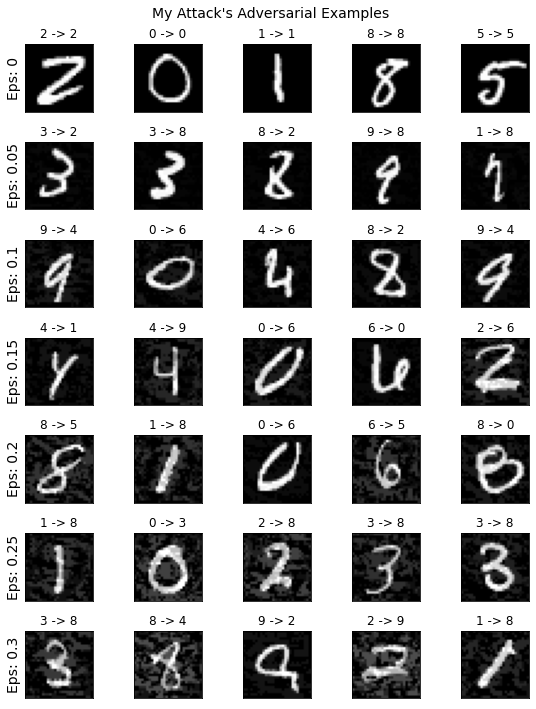

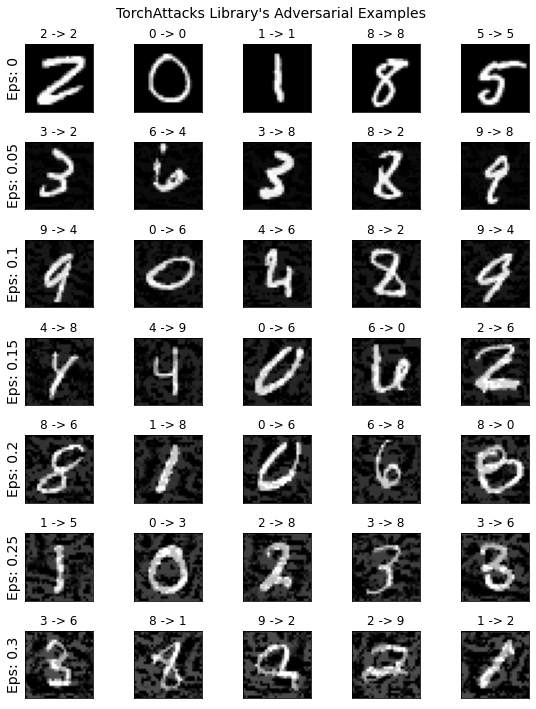

In [22]:
######################################################################
# Results
# -------
# 
# Accuracy vs Epsilon
# ~~~~~~~~~~~~~~~~~~~
# 
# The first result is the accuracy versus epsilon plot. As alluded to
# earlier, as epsilon increases we expect the test accuracy to decrease.
# This is because larger epsilons mean we take a larger step in the
# direction that will maximize the loss. Notice the trend in the curve is
# not linear even though the epsilon values are linearly spaced. For
# example, the accuracy at :math:`\epsilon=0.05` is only about 4% lower
# than :math:`\epsilon=0`, but the accuracy at :math:`\epsilon=0.2` is 25%
# lower than :math:`\epsilon=0.15`. Also, notice the accuracy of the model
# hits random accuracy for a 10-class classifier between
# :math:`\epsilon=0.25` and :math:`\epsilon=0.3`.
# 

plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "--", label = "My Attack")
plt.plot(epsilons, accuracies2, "--", label = "TorchAttacks Library")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


######################################################################
# Sample Adversarial Examples
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~
# 
# Remember the idea of no free lunch? In this case, as epsilon increases
# the test accuracy decreases **BUT** the perturbations become more easily
# perceptible. In reality, there is a tradeoff between accuracy
# degredation and perceptibility that an attacker must consider. Here, we
# show some examples of successful adversarial examples at each epsilon
# value. Each row of the plot shows a different epsilon value. The first
# row is the :math:`\epsilon=0` examples which represent the original
# “clean” images with no perturbation. The title of each image shows the
# “original classification -> adversarial classification.” Notice, the
# perturbations start to become evident at :math:`\epsilon=0.15` and are
# quite evident at :math:`\epsilon=0.3`. However, in all cases humans are
# still capable of identifying the correct class despite the added noise.
# 

# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
plt.suptitle("My Attack's Adversarial Examples", fontsize=14)
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
plt.suptitle("TorchAttacks Library's Adversarial Examples",fontsize=14)
for i in range(len(epsilons)):
    for j in range(len(examples2[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples2[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples2[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()




In [21]:
import pandas

df = pandas.DataFrame(data={"Epsilons":epsilons, "My Accuracy":accuracies, "Torchattacks Accuracy":accuracies2})
df

,Epsilons,My Accuracy,Torchattacks Accuracy
0,0.00,0.9810,0.9810
1,0.05,0.9278,0.9280
2,0.10,0.7609,0.7670
3,0.15,0.4114,0.4401
4,0.20,0.1005,0.1209
5,0.25,0.0100,0.0137
6,0.30,0.0000,0.0006
